## Importación de Librerías

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import r2_score
import pandas as pd
import keras
from keras import backend as K
import os
import PIL
import PIL.Image


print(tf.__version__)

2.12.0


## Generación de Sets de Entrenamiento y Validación

In [5]:
batch = 30
height = 150
width = 200
## dir='H:\Mi unidad\Maestría\Clases\8. Deep Learning\Proyecto Final\Talleres_DL_UELBosque\Imagenes\Mushrooms'
dir = 'C:/Users/nicol/Documents/Maestria/Deep Learning/Mushrooms/Talleres_DL_UELBosque/Imagenes/Mushrooms'

train_set = tf.keras.utils.image_dataset_from_directory(dir, 
                                                        labels='inferred',
                                                        seed=22081995,
                                                        validation_split=0.3, 
                                                        subset="training", 
                                                        image_size=(height, width), 
                                                        batch_size=batch)

test_set = tf.keras.utils.image_dataset_from_directory(dir, 
                                                        labels='inferred',
                                                        seed=22081995,
                                                        validation_split=0.3, 
                                                        subset="validation", 
                                                        image_size=(height, width), 
                                                        batch_size=batch)

class_names = train_set.class_names

Found 6700 files belonging to 9 classes.
Using 4690 files for training.
Found 6700 files belonging to 9 classes.
Using 2010 files for validation.


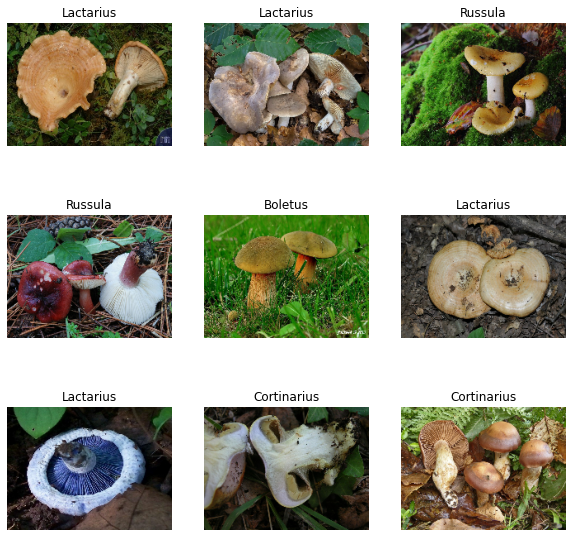

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  lbl=labels.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Detección de imagenes defectuosas

In [19]:
from PIL import Image

def is_jpeg_valid(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except:
        return False

In [25]:
files = dir
list = []
for raiz, carpetas, archivos in os.walk(files):
    for archivo in archivos:
        list.append(os.path.join(raiz, archivo))
df = pd.DataFrame({'archivos': list})
df.head(10)


,archivos
0,C:/Users/nicol/Documents/Maestria/Deep Learnin...
1,C:/Users/nicol/Documents/Maestria/Deep Learnin...
2,C:/Users/nicol/Documents/Maestria/Deep Learnin...
3,C:/Users/nicol/Documents/Maestria/Deep Learnin...
4,C:/Users/nicol/Documents/Maestria/Deep Learnin...
5,C:/Users/nicol/Documents/Maestria/Deep Learnin...
6,C:/Users/nicol/Documents/Maestria/Deep Learnin...
7,C:/Users/nicol/Documents/Maestria/Deep Learnin...
8,C:/Users/nicol/Documents/Maestria/Deep Learnin...
9,C:/Users/nicol/Documents/Maestria/Deep Learnin...


In [28]:
val = []
i_val = []
NoVal = []
i_NoVal = []

for i in list:
    if is_jpeg_valid(i):
        i_val.append(i)
        val.append('Válida')
    else:
        i_Noval.append(i)
        NoVal.append('No válida')

NoVal = pd.DataFrame({'Archivo':NoVal,'Estado':i_NoVal})
NoVal


,Archivo,Estado


## Data Argumentation

In [ ]:
def augment_data(images, labels):
    images = tf.image.resize(images,(150,110))
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_brightness(images, 0.05)
    return tf.cast(images, tf.float32) / 255., labels

def data_load(data_ds,augmented=augment_data,shuffle_=True ,batch_=10):
    data_ds = data_ds.map(
        augmented, num_parallel_calls=tf.data.AUTOTUNE)
    data_ds = data_ds.cache()
    if shuffle_:
        data_ds = data_ds.shuffle(len(data_ds))
    data_ds = data_ds.batch(batch_)
    data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds

In [24]:
data_train = data_load(train_set)
data_test = data_load(test_set,shuffle_=False)
for ds,lb in data_train.take(1):
    shaped=list(ds.shape)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext]